# Time Series Aanalysis

En este Notebook haremos uso de la libreria prophet de Facebook para predecir el precio del bitcoin en base al sentimiento en twitter en ese instante.

## Imports

In [21]:
import pandas as pd
import numpy as np

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objs as go

from JABA.service.scrapper import DFPicker

from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric


import json
from prophet.serialize import model_to_json, model_from_json

## Prophet

### Pick the data

En primer lugar establecemos las fechas de inicio y fin de los datos, que por una parte se usaran para entrenar el modelo, y por otra, para establecer las fechas de las que se quiere realizar la predeccion.
Para todo esto es **necesario tener en la carpeta de data los valores de bitcoin y el sentimiento de twitter**.
Haremos uso de la funcion **get_complete_df(dateFrom, dateTo)** de **DFPicker** para recopilar los datos de las fechas de las que queremos realizar la observacion:

In [22]:
date_init = "2017-01-01"
date_limit = "2021-06-10"
date_init_predict = "2021-06-11"
date_limit_predict = "2021-06-17"

In [23]:
def get_fit_predict_data(date_init, date_limit, date_init_predict, date_limit_predict):
    
    # Data for fitting the model
    fit_df = DFPicker.get_complete_df(date_init, date_limit)
    data = { 'ds': fit_df.index.values,
             'y': fit_df.Close,
             'sentiment_v': fit_df.sentiment_v,
             'sentiment_v2': fit_df.sentiment_v2
           }
    prophet_fit_df = pd.DataFrame(data, columns=['ds', 'y', 'sentiment_v', 'sentiment_v2'])
    prophet_fit_df.reset_index(drop=True, inplace=True)
    
    # Data for the prediction (sentiment and dates)
    future_data = DFPicker.get_complete_df(date_init_predict, date_limit_predict)
    future_data['date'] = future_data.index.values
    future_data['date'] = future_data['date'].dt.date
    grouped_data = future_data.groupby(['date']).agg({'sentiment_v' : 'mean' , 'sentiment_v2' : 'mean', 'Datetime':'count'})

    future_df = pd.concat([fit_df, grouped_data], ignore_index=False)
    future_df['ds'] = future_df.index.values
    future_df.Close.rename('y')
    print(future_df)
    
    return prophet_fit_df, future_df
    

Recojemos los datos referentes a las fechas establecidas anteriormente.

In [24]:
prophet_fit_df, future_df = get_fit_predict_data(date_init, date_limit, date_init_predict, date_limit_predict)

Current Date 2017-01-01
Current Date 2018-01-01
Current Date 2019-01-01
Current Date 2020-01-01
Current Date 2021-01-01
Current Date 2017-01-01
Current Date 2018-01-01
Current Date 2019-01-01
Current Date 2020-01-01
Current Date 2021-01-01
Extraction Completed!
Extraction Completed!
                     sentiment_v  Datetime  sentiment_v2       Close  \
2017-01-01 00:00:00    45.280772       125     40.843113  933.682667   
2017-01-01 00:30:00    27.436598        79     25.955371  966.378667   
2017-01-01 01:00:00    28.693411        85     26.123574  964.624000   
2017-01-01 01:30:00    18.457868        68     17.010161  963.622000   
2017-01-01 02:00:00    25.855075        88     22.976924  964.385667   
...                          ...       ...           ...         ...   
2021-06-12            622.553142        48    545.567656         NaN   
2021-06-13            837.207509        48    733.991905         NaN   
2021-06-14            952.728691        48    865.568814         NaN

### Model Evaluation

Definimos una funcion para comprobar si la prediccion del modelo es correcta

In [29]:
def model_score_lower_upper(forecast, real_data, upper_value):
    score = 0

    real_data = real_data.groupby(['date']).agg({'Close' : 'mean'})
    for prediction in forecast.values:
        i=1
        if(prediction[2] < real_data.iloc[i].Close):
            score += 1- upper_value
        if(prediction[3] > real_data.iloc[i].Close):
            score += upper_value
        i += 1
    score = score / forecast.shape[0]
    return score
    

In [26]:
model = Prophet()
model.add_regressor('sentiment_v')
model.add_regressor('sentiment_v2')
model.fit(prophet_fit_df)

forecast = model.predict(future_df)

In [32]:
score_upper_lower = model_score_lower_upper(forecast, future_data, 0.1)
score_lower = model_score_lower_upper(forecast, future_data, 0)
print("La puntuacion del modelo teniendo en cuenta el Upper y el Lower es de = ", score_upper_lower)
print("La puntuacion del modelo teniendo en el Lower es de = ", score_lower)
print("Estas son las predicciones realizadas por el modelo:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(120))


La puntuacion del modelo teniendo en cuenta el Upper y el Lower es de =  0.8405950606088366
La puntuacion del modelo teniendo en el Lower es de =  0.9241459778310754
Estas son las predicciones realizadas por el modelo:
                       ds          yhat    yhat_lower    yhat_upper
77015 2021-06-07 15:00:00  37048.500462  35061.222024  39071.096380
77016 2021-06-07 15:30:00  37165.192062  35167.101321  38976.286359
77017 2021-06-07 16:00:00  36785.918087  34887.547396  38669.742935
77018 2021-06-07 16:30:00  36516.987310  34571.793637  38460.522463
77019 2021-06-07 17:00:00  36571.357821  34749.460755  38517.357540
...                   ...           ...           ...           ...
77130 2021-06-12 00:00:00  35395.204700  33545.373497  37331.073071
77131 2021-06-13 00:00:00  35812.563359  33933.235280  37528.902389
77132 2021-06-14 00:00:00  35699.681517  33809.385196  37698.776449
77133 2021-06-15 00:00:00  35263.599880  33299.507622  37151.832902
77134 2021-06-16 00:00:00  34762.

### Plotting the results

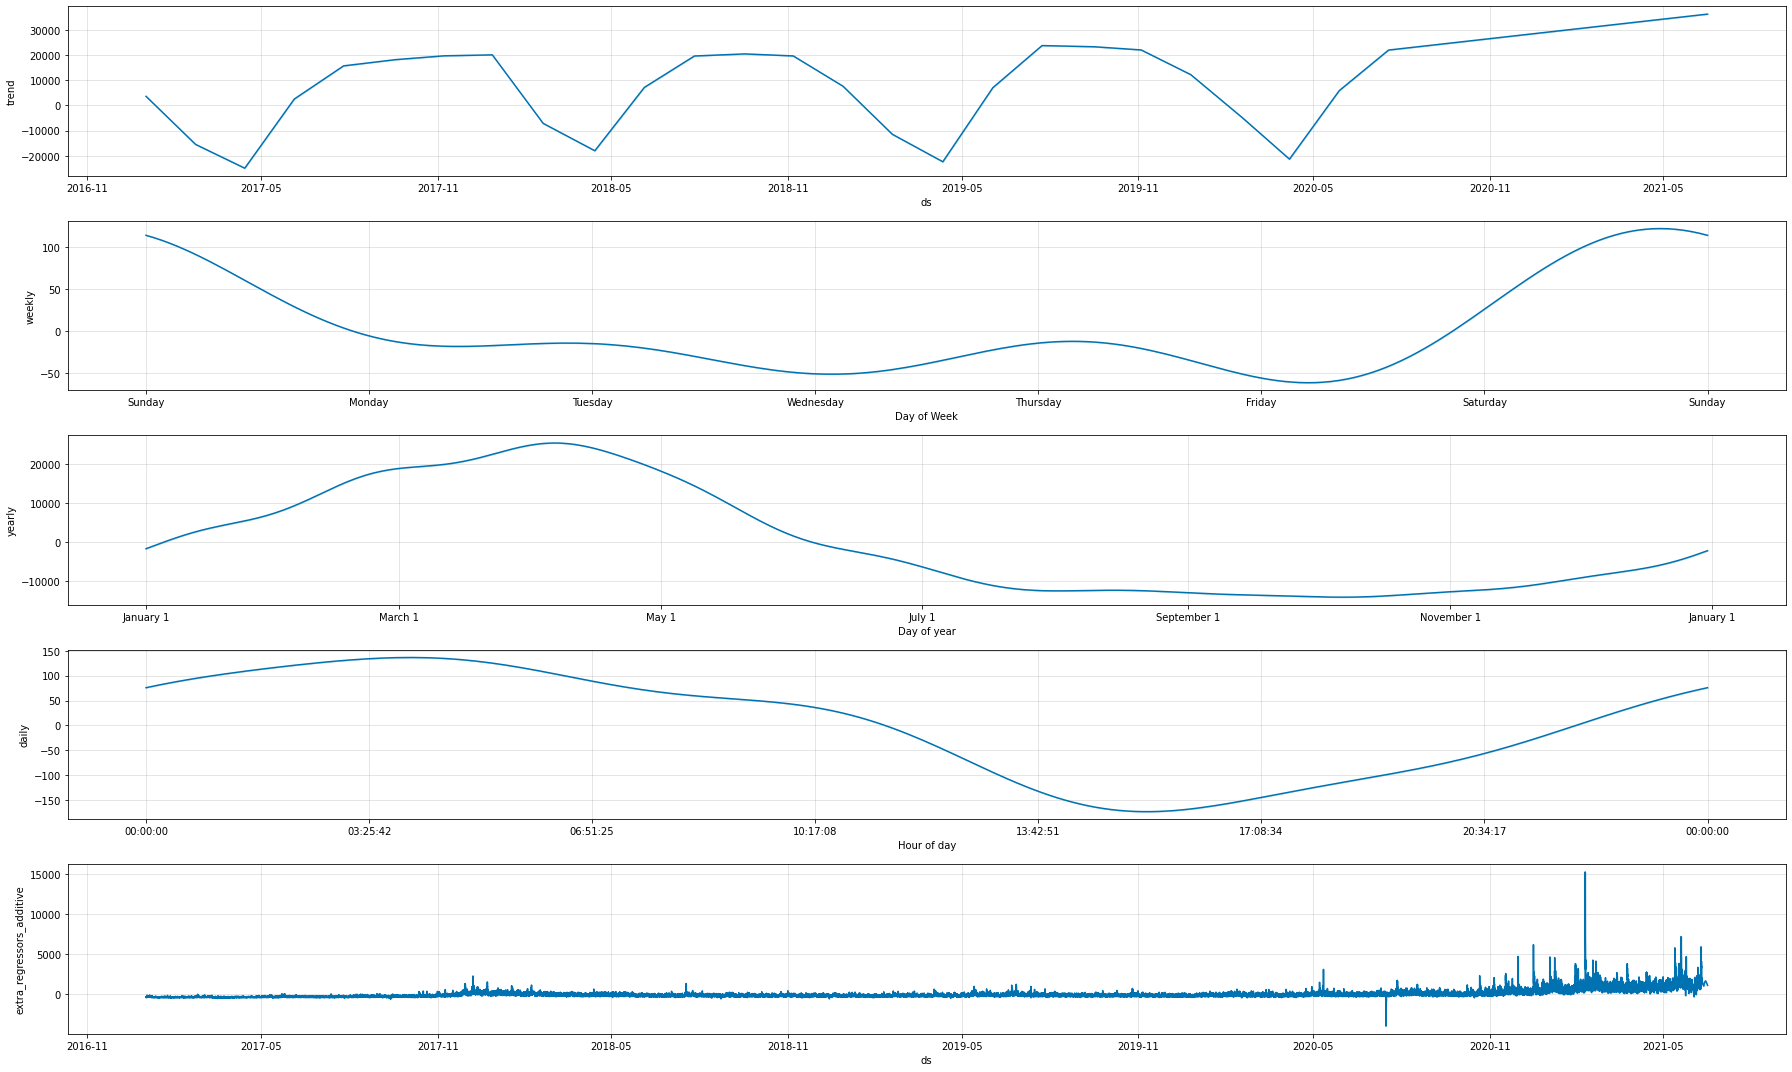

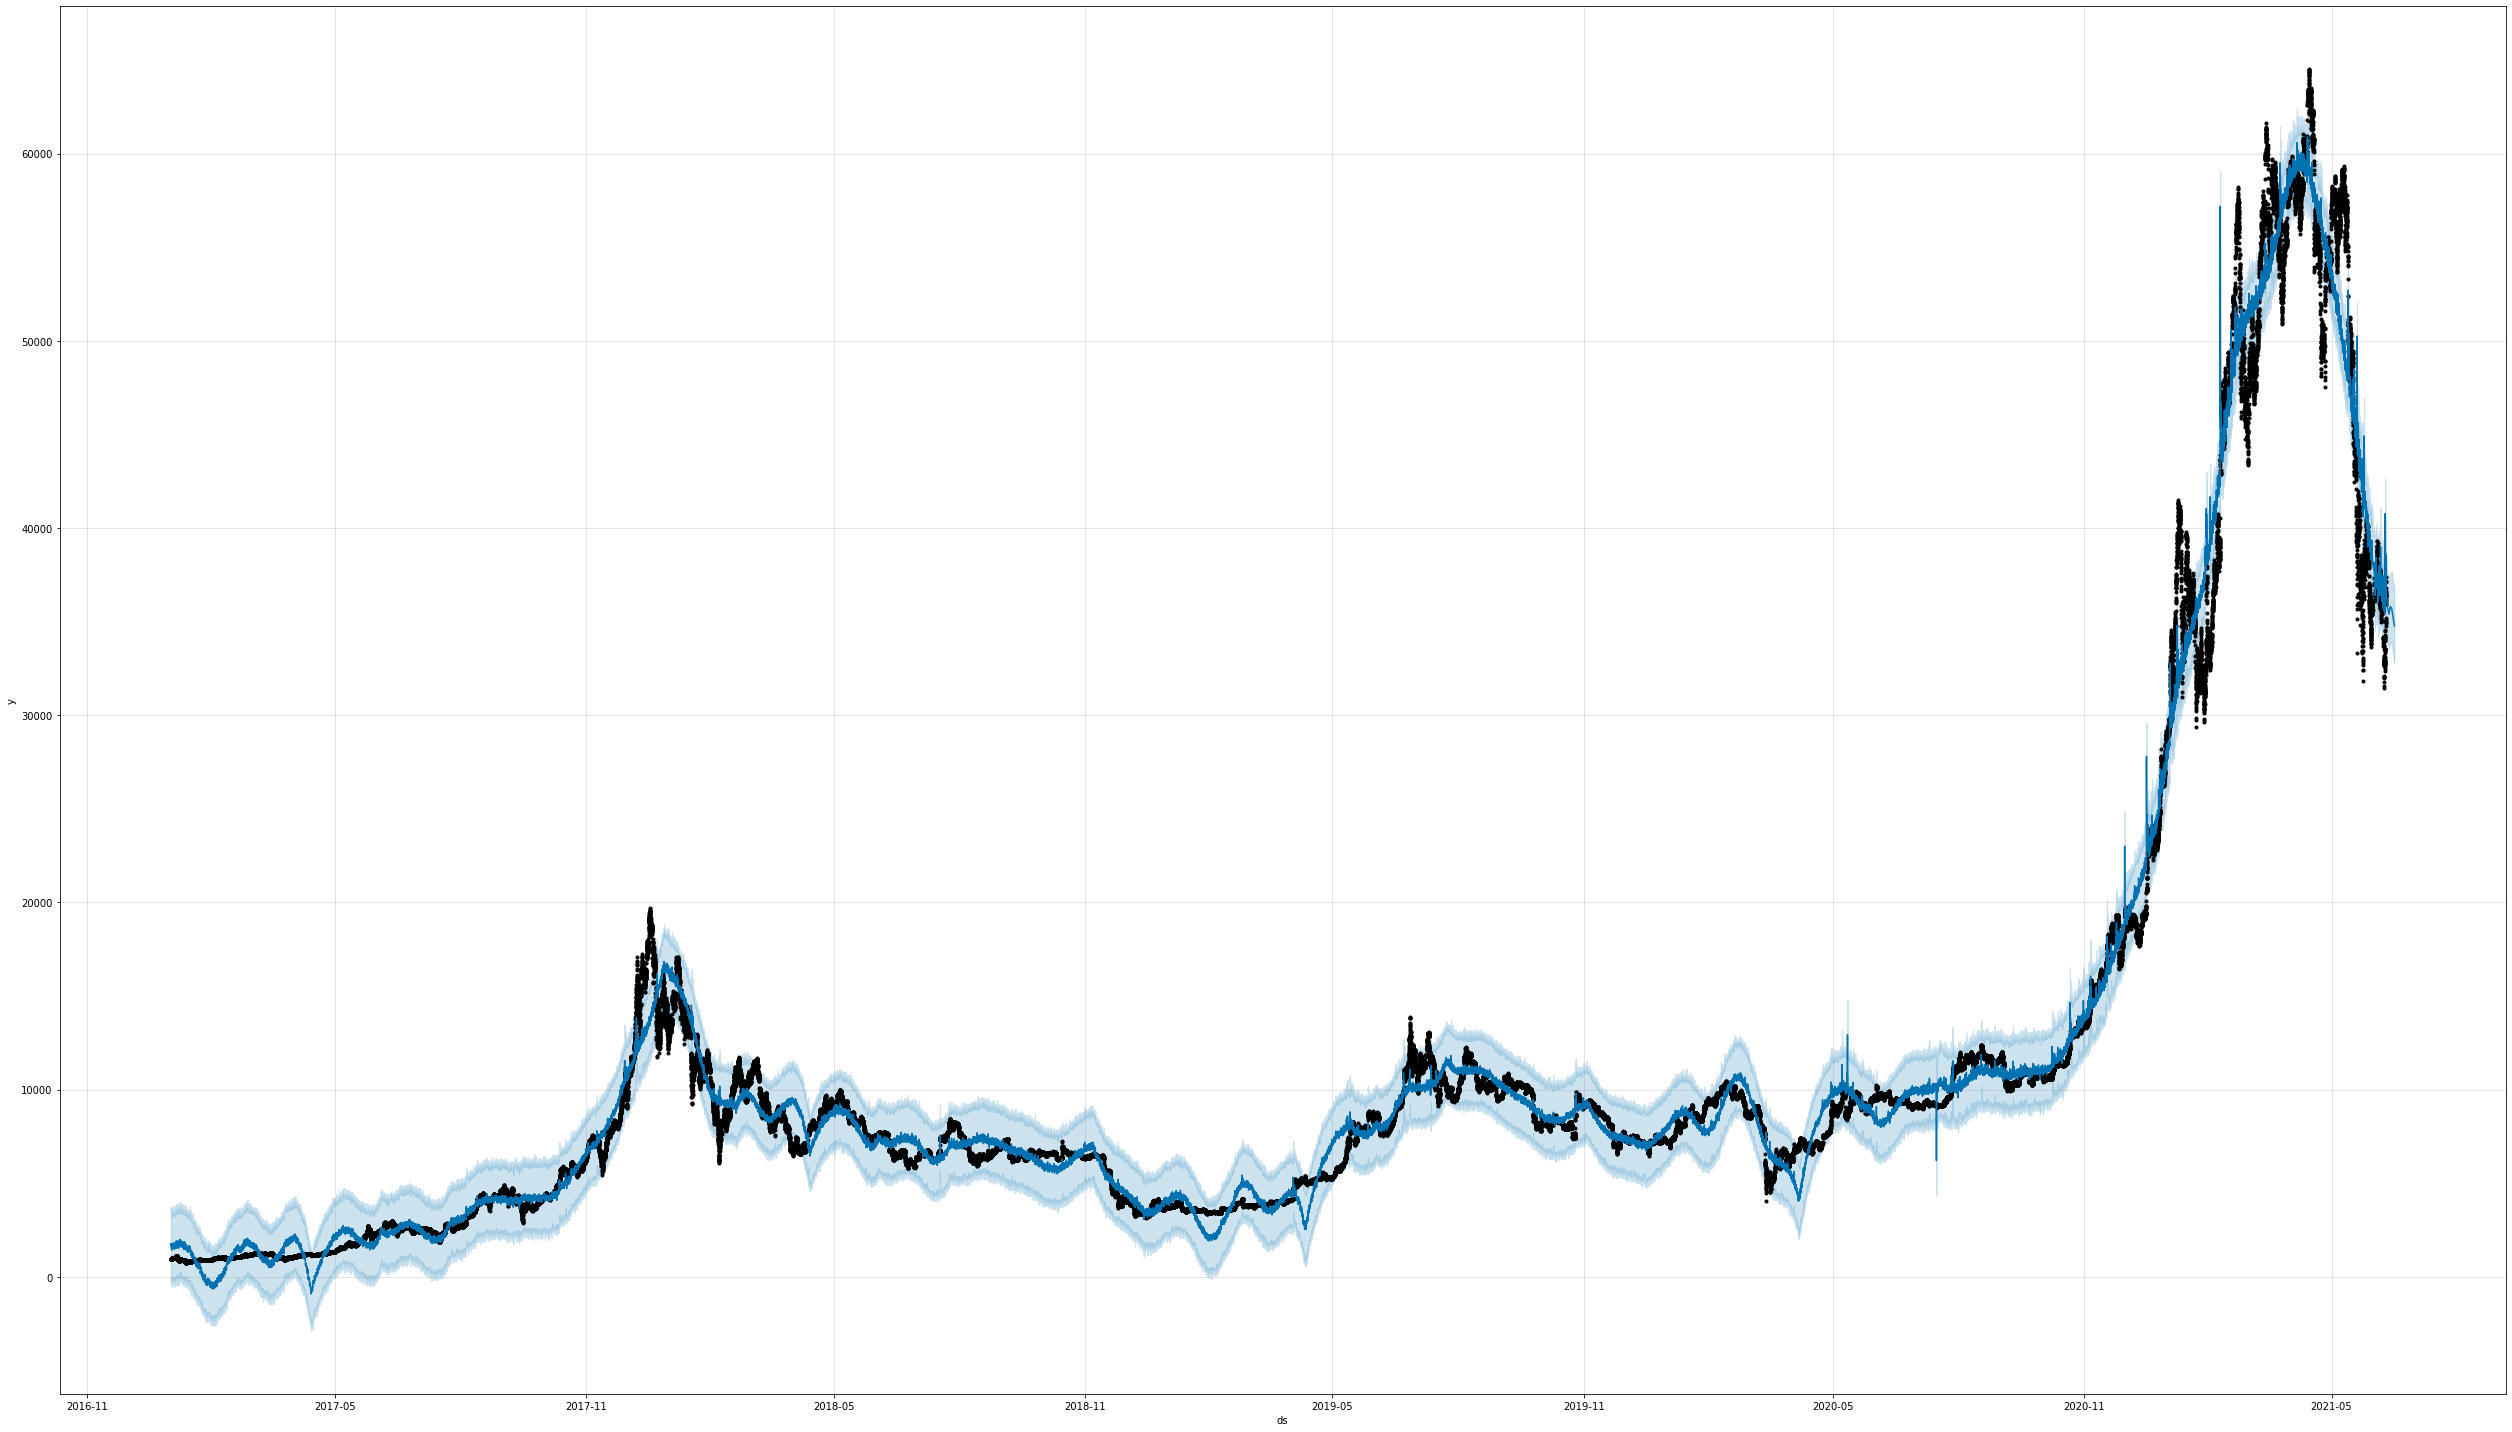

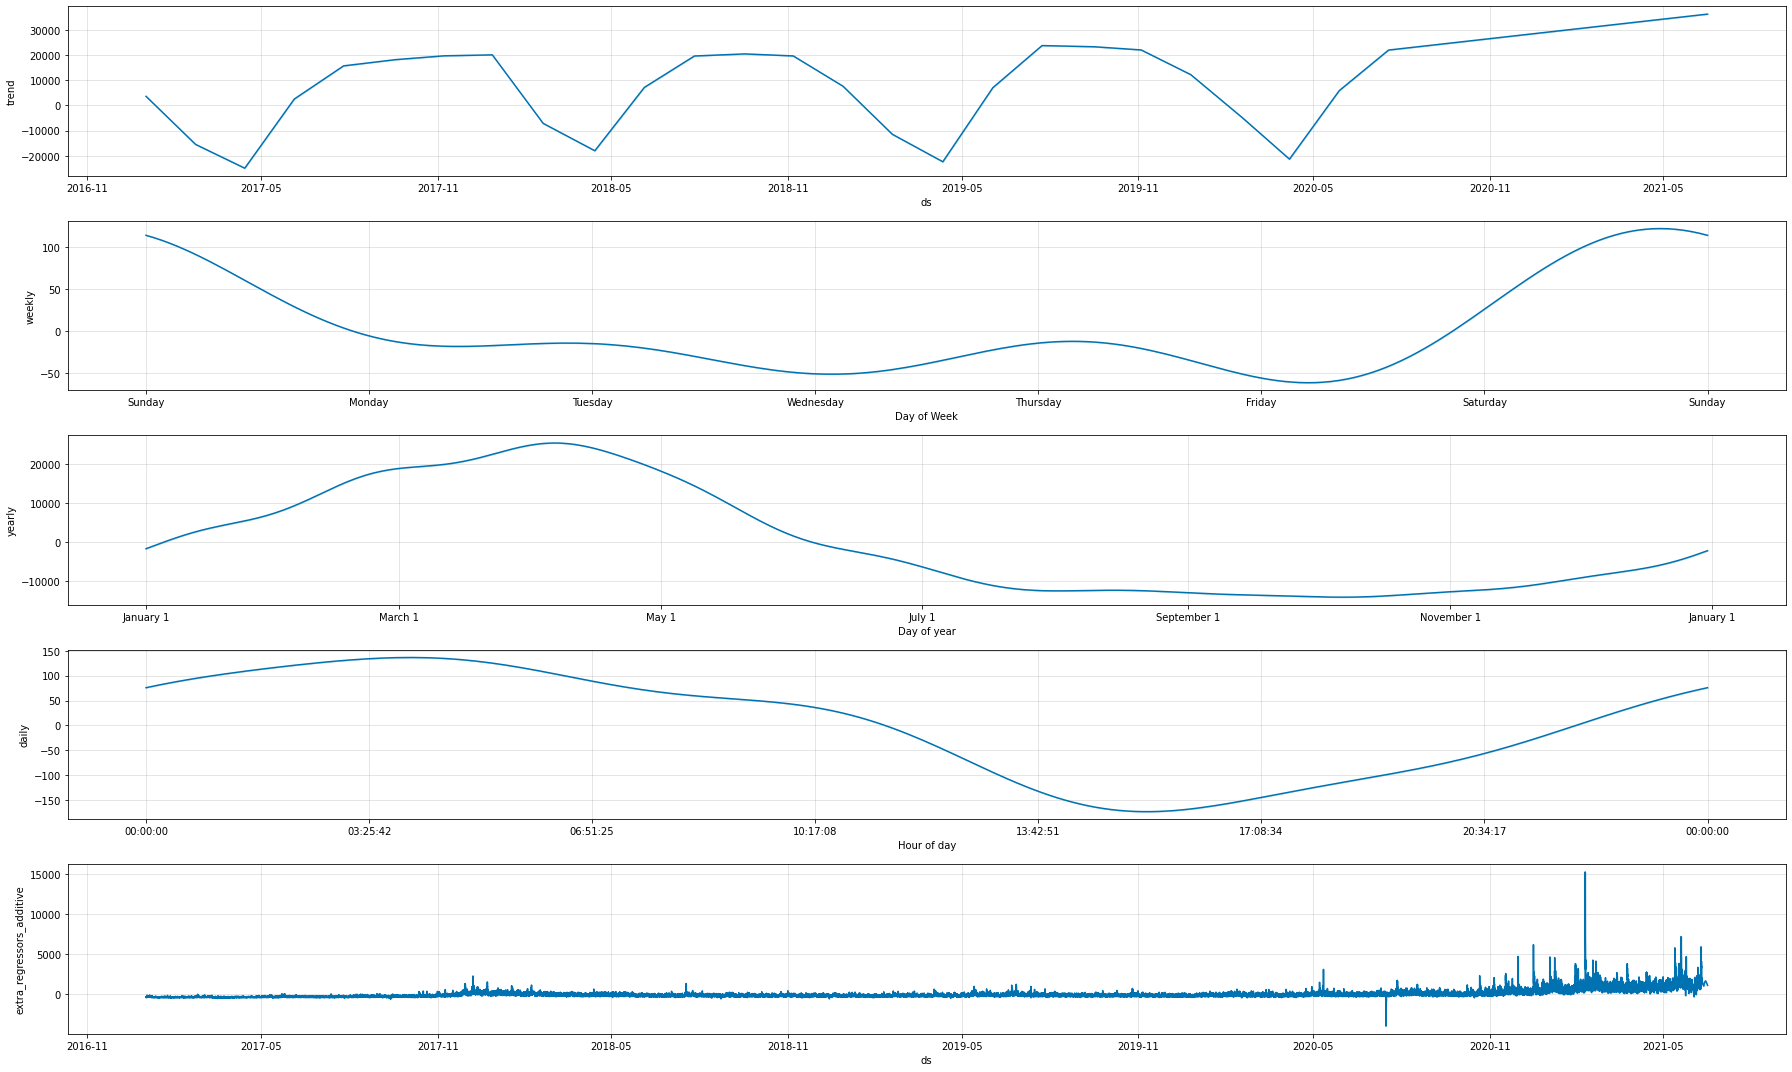

In [35]:
model.plot(forecast, figsize=(35, 20))
model.plot_components(forecast, figsize=(25, 15))

### Save the model

Podemos guardar nuestro modelo entrenado para poder hacer uso de el en un futuro.

In [37]:
with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(model), fout) 

### Load the model

Podemos cargar el modelo guardado anteriormente de la siguiente manera

In [38]:
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  

### Updating the model

Function to reduce the updating time

In [39]:
def stan_init(m):
    """Retrieve parameters from a trained model.
    
    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.
    
    Parameters
    ----------
    m: A trained model of the Prophet class.
    
    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

In [41]:
df_fit_updated, df_predict_updated = get_fit_predict_data("2021-06-16", "2021-06-17", "2021-06-16", "2021-06-17")
model_updated = Prophet().fit(df_fit_updated, init=stan_init(m))

Extraction Completed!


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.


Extraction Completed!
                     sentiment_v  Datetime  sentiment_v2         Close  \
2021-06-16 00:00:00   625.447739      1549    537.706773  40053.852667   
2021-06-16 00:30:00   657.342819      1474    584.204581  39968.066333   
2021-06-16 01:00:00   464.662718      1323    411.595789  39773.420000   
2021-06-16 01:30:00   505.920071      1290    451.565326  39987.318000   
2021-06-16 02:00:00   604.797548      1252    541.910797  40101.221333   
2021-06-16 02:30:00   530.957895      1255    471.638455  40039.838667   
2021-06-16 03:00:00   659.761331      1284    586.890359  39907.870667   
2021-06-16 03:30:00   525.541621      1228    454.994037  39991.239333   
2021-06-16 04:00:00   546.786415      1189    484.436726  39955.706000   
2021-06-16 04:30:00   636.812094      1260    563.670613  40285.468333   
2021-06-16 05:00:00   550.738081      1252    496.687140  40241.745667   
2021-06-16 05:30:00   583.131263      1219    524.917588  40273.383000   
2021-06-16 06:00

RuntimeError: mismatch in dimension declared and found in context; processing stage=parameter initialization; variable name=delta; position=0; dims declared=(24); dims found=(25)

## Cross validation

In [ ]:
df_cv = cross_validation(model, initial='900 days', period='120 days', horizon = '5 days', parallel="processes")
df_cv.head(100)


In [17]:
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
212,4 days 22:00:00,1.441238e+07,3796.363397,2337.543926,0.079237,0.072268,0.081189,0.555556
213,4 days 22:30:00,1.437255e+07,3791.114227,2323.500072,0.078697,0.072094,0.080703,0.562500
214,4 days 23:00:00,1.440019e+07,3794.757864,2314.937396,0.078467,0.072094,0.080520,0.569444
215,4 days 23:30:00,1.433596e+07,3786.285564,2298.470790,0.078106,0.071697,0.080217,0.576389
216,5 days 00:00:00,1.424565e+07,3774.340817,2282.413356,0.077868,0.071083,0.080026,0.583333


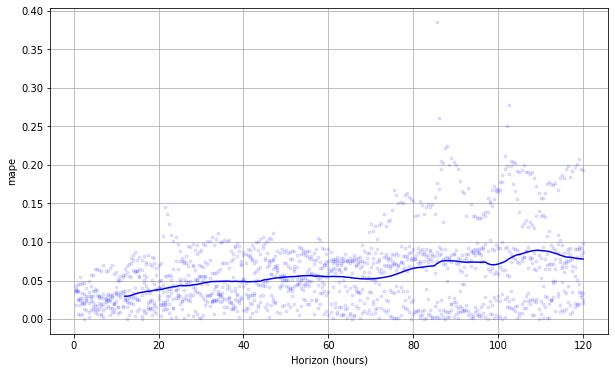

In [18]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Hyperparameter Tunning

Para ajustar el modelo haremos uso de cross-validation con diferentes parametros, en busca del mejor resultado

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
iteration = 0
for params in all_params:
    model = Prophet(**params).add_regressor('sentiment_v').add_regressor('sentiment_v2').fit(prophet_fit_df)
    df_cv = cross_validation(model, initial='1825 days', period='150 days', horizon = '2 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    iteration +=1 
    print(iteration)
    

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)